## This Notebook Uses ReSNet50 (Transfer Learning with PreTrained Weights and Retraining) Model to generate Output Predictions

#  <font color='red'>Table of Contents</font>


[9. ResNet50 Models](#section9)<br>


In [3]:
# Research Kernel Link - https://github.com/dimitreOliveira/APTOS2019BlindnessDetection/blob/master/Model%20backlog/ResNet50/4%20-%20ResNet50%20-%20Batch%20size%2022.ipynb

import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

4  CPU cores


#  <a id = 'section9'> <font color='red'>  9. ResNet50 Models  </font> </a>

### <font color='red'> 9.1 Setup Colab Environment </font>

In [4]:
from google.colab import drive
import os

# Parameters
DATASET_PATH = '/content/drive/My Drive/University Of Stirling/Dissertation/Online Implementations/Tymchenko_ResNet50/APTOS2019'

drive.mount('/content/drive')

os.chdir(DATASET_PATH)
print("CWD:",os.getcwd())

Mounted at /content/drive
CWD: /content/drive/MyDrive/University Of Stirling/Dissertation/Online Implementations/Tymchenko_ResNet50/APTOS2019


In [5]:
def load_data():
    file = open('df_train_train', 'rb')
    df_train_train = pickle.load(file)
    file.close()

    file = open('df_train_test', 'rb')
    df_train_test = pickle.load(file)
    file.close()
    
    return df_train_train,df_train_test

In [6]:
df_train_train,df_train_test = load_data()
print(df_train_train.shape,df_train_test.shape,'\n')
df_train_train.head(6)

(2929, 4) (1099, 4) 



,id_code,diagnosis,file_path,file_name
665,2f7789c1e046,4,./train_images/2f7789c1e046.png,2f7789c1e046.png
557,278aa860dffd,1,./train_images/278aa860dffd.png,278aa860dffd.png
676,300305ce82d2,2,./train_images/300305ce82d2.png,300305ce82d2.png
3145,da1fb35f5df9,1,./train_images/da1fb35f5df9.png,da1fb35f5df9.png
1959,89fc080f7e83,2,./train_images/89fc080f7e83.png,89fc080f7e83.png
3074,d6228d951958,2,./train_images/d6228d951958.png,d6228d951958.png


### <font color='red'> 9.2 Image Pre Processing </font>

In [7]:
IMG_SIZE = 512

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))

In [ ]:
'''This Function uses Multi processing for faster saving of images into folder'''

def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

In [ ]:
# Use 2 cores (colab)
# ref - https://stackoverflow.com/questions/1006289/how-to-find-out-the-number-of-cpus-using-python

#multiprocess_image_processor(2, list(df_train_train.id_code.values))

### <font color='red'> 9.3 Train Model </font>

In [8]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [9]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="./train_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "./test_images_resized_preprocessed/",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator

In [10]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 2344 validated image filenames belonging to 5 classes.
Found 585 validated image filenames belonging to 5 classes.
Found 1099 validated image filenames.


In [23]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.utils.data_utils import get_file

WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)

    '''
    weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models',
                                    md5_hash='a268eb855778b3df3c7506639542a6af')
    
    base_model.load_weights(weights_path)
    '''

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [24]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94781440/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)           

In [25]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

293 73


In [27]:
model.compile(optimizer = tf.keras.optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/2
293/293 [==============================] - 1906s 6s/step - loss: 2.0171 - accuracy: 0.3925 - val_loss: 1.2866 - val_accuracy: 0.5051
Epoch 2/2
293/293 [==============================] - 30s 103ms/step - loss: 1.3876 - accuracy: 0.4565 - val_loss: 1.2821 - val_accuracy: 0.5051


In [28]:
from keras.metrics import FalseNegatives
import tensorflow as tf

for layer in model.layers:
    layer.trainable = True

CHECKPOINT_PATH = DATASET_PATH + "/checkpoints/"

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callback_list = [es, rlrop, checkpoint]
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 326, 326, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 160, 160, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 40, 40, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 40, 40, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 40, 40, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 40, 40, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization) 

In [29]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/40
293/293 [==============================] - 66s 202ms/step - loss: 0.3259 - accuracy: 0.6822 - val_loss: 0.4457 - val_accuracy: 0.5959 - lr: 1.0000e-04
Epoch 2/40
293/293 [==============================] - 38s 130ms/step - loss: 0.2271 - accuracy: 0.7521 - val_loss: 0.4660 - val_accuracy: 0.5325 - lr: 1.0000e-04
Epoch 3/40
293/293 [==============================] - 59s 200ms/step - loss: 0.2086 - accuracy: 0.7730 - val_loss: 0.2119 - val_accuracy: 0.7723 - lr: 1.0000e-04
Epoch 4/40
293/293 [==============================] - 57s 196ms/step - loss: 0.1784 - accuracy: 0.8033 - val_loss: 0.1901 - val_accuracy: 0.8031 - lr: 1.0000e-04
Epoch 5/40
293/293 [==============================] - 59s 201ms/step - loss: 0.1600 - accuracy: 0.8323 - val_loss: 0.1635 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 6/40
293/293 [==============================] - 38s 130ms/step - loss: 0.1458 - accuracy: 0.8417 - val_loss: 0.2315 - val_accuracy: 0.8065 - lr: 1.0000e-04
Epoch 7/40
293/293 [========

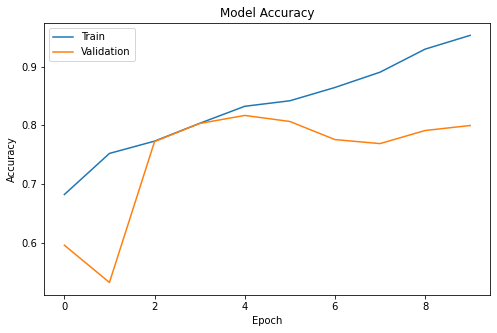

In [30]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

### <font color='red'> 9.4 Generate Train Predictions on complete Train Data </font>

In [31]:
complete_datagen = ImageDataGenerator(rescale=1./255)
complete_generator = complete_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                          directory = "./train_images_resized_preprocessed/",
                                                          x_col="file_name",
                                                          target_size=(HEIGHT, WIDTH),
                                                          batch_size=1,
                                                          shuffle=False,
                                                          class_mode=None)

STEP_SIZE_COMPLETE = complete_generator.n//complete_generator.batch_size
train_preds = model.predict_generator(complete_generator, steps=STEP_SIZE_COMPLETE,verbose = 1)
train_preds = [np.argmax(pred) for pred in train_preds]

Found 2929 validated image filenames.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


2929/2929 [==============================] - 37s 12ms/step


In [32]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, df_train_train['diagnosis'].astype('int'), weights='quadratic'))
print("Train Accuracy score : %.3f" % accuracy_score(df_train_train['diagnosis'].astype('int'),train_preds))

Train Cohen Kappa score: 0.919
Train Accuracy score : 0.884


### <font color='red'> 9.5 Evaluate Model on Test Data </font>

In [33]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
test_preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


1099/1099 [==============================] - 587s 534ms/step


In [34]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g')
    #sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
    plt.show()

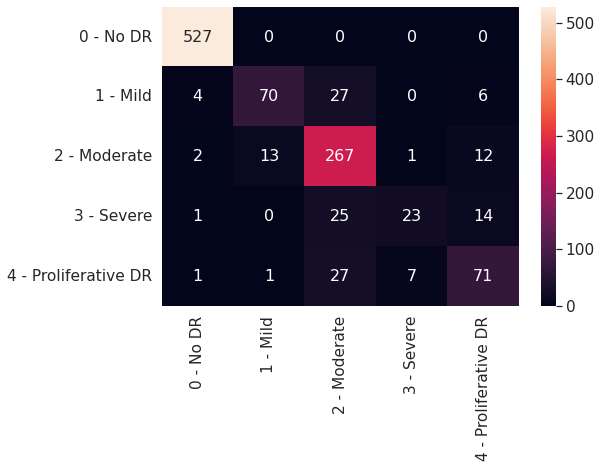

In [35]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(df_train_test['diagnosis'].astype(int)),test_labels,labels)

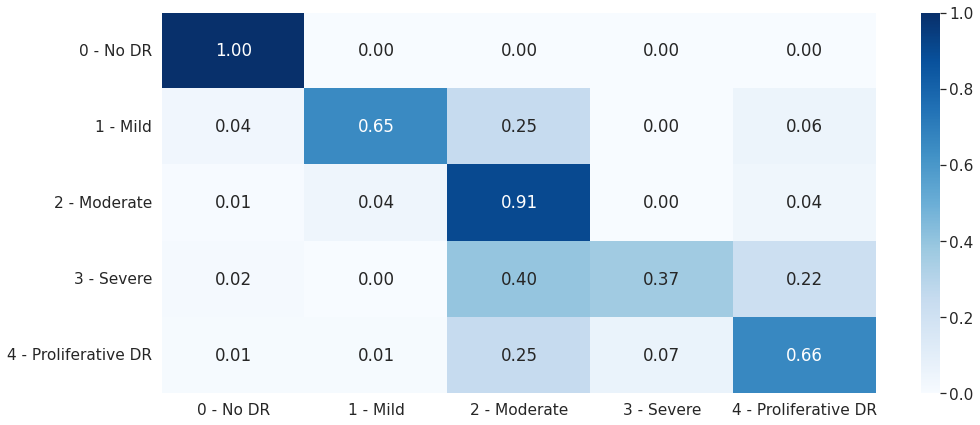

In [36]:
cnf_matrix = confusion_matrix(df_train_test['diagnosis'].astype('int'), test_labels)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

In [37]:
print("Test Cohen Kappa score: %.3f" % cohen_kappa_score(test_labels, df_train_test['diagnosis'].astype('int'), weights='quadratic'))
print("Test Accuracy score : %.3f" % accuracy_score(df_train_test['diagnosis'].astype('int'),test_labels))

Test Cohen Kappa score: 0.912
Test Accuracy score : 0.872


### <font color='red'> 9.6 ResNet50 Models Summary </font>

In [38]:
x = PrettyTable()
x.field_names = ["S.No.","ResNet50 Model","Image Processing","Data Augmentation","Hyperparameters(BS,Opt,lr,ep)","Train QWK","Test QWK"]

x.add_row([1,"R-P-D-p(0.5)-D-p(0.5)-S(5)","--","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.912","0.905"])
x.add_row([2,"R-P-D-p(0.5)-D-p(0.5)-S(5)","Circle Crop, Gaussian Blur","Hor Flip,Scale 1/255","(4,'Adam','1e-4',7)","0.98","0.904"])

print(x)

+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
| S.No. |       ResNet50 Model       |      Image Processing      |  Data Augmentation   | Hyperparameters(BS,Opt,lr,ep) | Train QWK | Test QWK |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
|   1   | R-P-D-p(0.5)-D-p(0.5)-S(5) |             --             | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |   0.912   |  0.905   |
|   2   | R-P-D-p(0.5)-D-p(0.5)-S(5) | Circle Crop, Gaussian Blur | Hor Flip,Scale 1/255 |      (4,'Adam','1e-4',7)      |    0.98   |  0.904   |
+-------+----------------------------+----------------------------+----------------------+-------------------------------+-----------+----------+
